## Deterministic Policy Gradient (DPG)

In policy gradient methods (REINFORCE, A2C, PPO), the policy is stochastic:

$$
\pi_\theta(a|s) = P(a|s;\theta)
$$

However, in continuous action spaces, sampling from a probability distribution can add unnecessary variance. If the environment is deterministic (or nearly so), a deterministic policy may be more efficient.

DPG proposes learning a deterministic policy:

$$
\mu_{\theta}(s) : S \to A
$$

that directly maps states to a single action

## Objective function

We want to maximize the expected return under the deterministic policy:

$$
J(\theta) = \mathbb{E}_{s \sim \rho^{\mu}} \left[ Q^{\mu}(s, \mu_{\theta}(s)) \right]
$$

where $\rho^{\mu}(s)$ is the discounted state distribution under policy $\mu$.

## Deterministic Policy Gradient Theorem

The gradient of $J(\theta)$ can be derived as (based on the theorem):

$$
\nabla_{\theta} J(\theta) = \mathbb{E}_{s \sim \rho^{\mu}} \left[ \nabla_{\theta} \mu_{\theta}(s) \, \nabla_{a} Q^{\mu}(s,a) \big|_{a=\mu_{\theta}(s)} \right]
$$

This result is powerful: instead of summing over all actions (as in stochastic PG), we only need to evaluate the gradient of the critic $Q(s,a)$ w.r.t. the action at the current policy action.

Since we don’t know the true $Q^{\mu}$, we approximate it with a critic network. This leads to the Actor-Critic structure that we are familiar with.

Critic (Q-network):
Approximates $Q(s,a)$, trained by minimizing TD error:

$$
L(\phi) = \mathbb{E} \left[ \left( r + \gamma Q_{\phi}(s', \mu_{\theta}(s')) - Q_{\phi}(s,a) \right)^2 \right]
$$

Actor (policy network):
Updated by ascending the deterministic policy gradient:

$$
\nabla_{\theta} J(\theta) \approx \mathbb{E}_{s \sim D} \left[ \nabla_{\theta} \mu_{\theta}(s) \, \nabla_{a} Q_{\phi}(s,a) \big|_{a=\mu_{\theta}(s)} \right]
$$

Where:
- $\phi$ are the critic network parameters
- $\theta$ are the actor network parameters  
- $D$ is the experience replay buffer
- $\gamma$ is the discount factor

## Exploration
Exploration

A deterministic policy has no built-in exploration.
So in practice, we add noise to the action during training:

$$
a_t = \mu_{\theta}(s_t) + \mathcal{N}_t
$$

where $\mathcal{N}_t$ is usually Gaussian noise.

## TD3: Twin Delayed Deep Deterministic Policy Gradient

TD3 addresses three key issues in DDPG that can lead to overestimation and training instability:

1. Overestimation Bias in Q-Learning

In DDPG, the same Q-network is used to select and evaluate actions, leading to overestimation:

$$
y = r + \gamma Q_{\phi}(s', \mu_{\theta}(s'))
$$

2. High Variance of Target Values

The moving target problem is exacerbated by frequent policy updates.

3. Accumulating Errors

Small Q-function errors can propagate and amplify over time.

### TD3 Solution

1. Clipped Double Q-Learning

TD3 maintains two independent critic networks and uses the smaller of the two Q-values to help reduce overestimation:

$$
y = r + \gamma \, \min_{i=1,2} Q_{\phi_i'}(s', \mu_{\theta'}(s'))
$$

2. Target Policy Smoothing

Add noise to the target action to make the policy less exploitable of Q-function errors:

$$
\tilde{a} = \mu_{\theta'}(s') + \epsilon, \quad \epsilon \sim \text{clip}(\mathcal{N}(0, \sigma), -c, c)
$$

The target update becomes:

$$
y = r + \gamma \, \min_{i=1,2} Q_{\phi_i'}(s', \tilde{a})
$$

3. Delayed Policy Updates

Update the policy (actor) less frequently than the value function (critic). Typically, update the actor once for every two critic updates.

In [ ]:
!pip install gymnax

In [34]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
import flax.linen as nn
import gymnax
import time

# ---------------------------
# Actor & Critic Networks
# ---------------------------
class Actor(nn.Module):
    action_dim: int
    hidden_sizes: tuple = (256, 128)  # Larger networks as in TD3 paper

    @nn.compact
    def __call__(self, x):
        for h in self.hidden_sizes:
            x = nn.relu(nn.Dense(h)(x))
        x = nn.tanh(nn.Dense(self.action_dim)(x))  # action in [-1,1]
        return x * 2.0  # Scale to [-2, 2] for Pendulum


class Critic(nn.Module):
    hidden_sizes: tuple = (256, 128)  # Larger networks

    @nn.compact
    def __call__(self, state, action):
        x = jnp.concatenate([state, action], axis=-1)
        for h in self.hidden_sizes:
            x = nn.relu(nn.Dense(h)(x))
        q = nn.Dense(1)(x)
        return q.squeeze(-1)


# ---------------------------
# Utilities
# ---------------------------
def make_env(num_envs, seed=0):
    env, env_params = gymnax.make("Pendulum-v1")
    rng = random.PRNGKey(seed)

    def reset_fn(rng):
        rngs = random.split(rng, num_envs)
        obs, states = jax.vmap(env.reset, in_axes=(0, None))(rngs, env_params)
        return obs, states, rngs

    def step_fn(rngs, states, actions):
        rngs = jax.vmap(random.split)(rngs)[:, 0]  # advance rng
        obs, states, rewards, dones, _ = jax.vmap(env.step, in_axes=(0, 0, 0, None))(
            rngs, states, actions, env_params
        )
        return obs, states, rewards, dones, rngs

    return reset_fn, step_fn, env_params

def soft_update(target_params, main_params, tau=0.005):
    return jax.tree_util.tree_map(lambda t, m: tau * m + (1 - tau) * t, target_params, main_params)


# ---------------------------
# TD3-Specific Functions
# ---------------------------
@jit
def add_target_noise(action, noise_clip=0.5, target_noise=0.2, rng=None):
    """TD3-style target policy smoothing"""
    noise = random.normal(rng, action.shape) * target_noise
    noise = jnp.clip(noise, -noise_clip, noise_clip)
    noisy_action = action + noise
    return jnp.clip(noisy_action, -2.0, 2.0)  # Clip to Pendulum action range


# ---------------------------
# Main Training Loop with TD3
# ---------------------------
def train(num_envs=32, num_episodes=200, batch_size=256, max_buffer=1000000):  # Larger batch size
    reset_fn, step_fn, _ = make_env(num_envs)
    step_fn = jax.jit(step_fn)

    # TD3 Hyperparameters
    gamma = 0.99
    tau = 0.005  # Soft update rate
    policy_noise = 0.2  # Target policy noise
    noise_clip = 0.5  # Target noise clip
    policy_freq = 2  # Delayed policy update (update actor every 2 critic updates)

    # Init networks
    dummy_state = jnp.zeros((num_envs, 3))
    actor = Actor(action_dim=1)
    critic1 = Critic()
    critic2 = Critic()

    # Initialize parameters
    actor_key, critic1_key, critic2_key = random.split(random.PRNGKey(0), 3)
    actor_params = actor.init(actor_key, dummy_state)
    critic1_params = critic1.init(critic1_key, dummy_state, jnp.zeros((num_envs, 1)))
    critic2_params = critic2.init(critic2_key, dummy_state, jnp.zeros((num_envs, 1)))

    # Target networks
    target_actor_params = jax.tree_util.tree_map(lambda x: x, actor_params)
    target_critic1_params = jax.tree_util.tree_map(lambda x: x, critic1_params)
    target_critic2_params = jax.tree_util.tree_map(lambda x: x, critic2_params)

    # JIT applies
    actor_apply = jax.jit(actor.apply)
    critic1_apply = jax.jit(critic1.apply)
    critic2_apply = jax.jit(critic2.apply)

    # Optimizers (slightly lower learning rates for stability)
    actor_opt = optax.adam(3e-4)
    critic1_opt = optax.adam(1e-3)
    critic2_opt = optax.adam(1e-3)

    # Init optimizers
    opt_state_actor = actor_opt.init(actor_params)
    opt_state_critic1 = critic1_opt.init(critic1_params)
    opt_state_critic2 = critic2_opt.init(critic2_params)

    # ---------------------------
    # JIT update step with TD3 features
    # ---------------------------
    @jax.jit
    def update_step(actor_params, critic_params, target_actor_params, target_critic_params,
                   opt_state_actor, opt_state_critic, batch, rng, step_count):
        states, actions, rewards, next_states, dones = batch
        critic1_params, critic2_params = critic_params
        target_critic1_params, target_critic2_params = target_critic_params
        opt_state_critic1, opt_state_critic2 = opt_state_critic

        # Split RNG for noise
        rng1, rng2, rng3 = random.split(rng, 3)

        update_actor = (step_count % policy_freq) == 0

        # TD3: Target policy smoothing and clipped double Q-learning
        target_actions = actor_apply(target_actor_params, next_states)
        noisy_target_actions = add_target_noise(target_actions, noise_clip, policy_noise, rng1)

        # Clipped double Q-learning
        q1_target = critic1_apply(target_critic1_params, next_states, noisy_target_actions)
        q2_target = critic2_apply(target_critic2_params, next_states, noisy_target_actions)
        min_q_target = jnp.minimum(q1_target, q2_target)
        target_q = rewards + gamma * (1 - dones) * min_q_target

        # Critic losses (both critics use same target)
        def critic1_loss_fn(params):
            q_pred = critic1_apply(params, states, actions)
            return jnp.mean((q_pred - target_q) ** 2)

        def critic2_loss_fn(params):
            q_pred = critic2_apply(params, states, actions)
            return jnp.mean((q_pred - target_q) ** 2)

        # Update critics
        loss_c1, grads1 = jax.value_and_grad(critic1_loss_fn)(critic1_params)
        updates1, new_opt_state_c1 = critic1_opt.update(grads1, opt_state_critic1, critic1_params)
        new_critic1_params = optax.apply_updates(critic1_params, updates1)

        loss_c2, grads2 = jax.value_and_grad(critic2_loss_fn)(critic2_params)
        updates2, new_opt_state_c2 = critic2_opt.update(grads2, opt_state_critic2, critic2_params)
        new_critic2_params = optax.apply_updates(critic2_params, updates2)

        # TD3: Delayed policy update
        def update_actor_fn():
            def actor_loss_fn(params):
                current_actions = actor_apply(params, states)
                q1 = critic1_apply(new_critic1_params, states, current_actions)
                return -jnp.mean(q1)  # TD3 uses only Q1 for policy update

            actor_grads = jax.grad(actor_loss_fn)(actor_params)
            updates, new_opt_state_actor = actor_opt.update(actor_grads, opt_state_actor)
            new_actor_params = optax.apply_updates(actor_params, updates)
            return new_actor_params, new_opt_state_actor

        def no_update_actor_fn():
            return actor_params, opt_state_actor

        # Conditionally update actor
        new_actor_params, new_opt_state_actor = jax.lax.cond(
            update_actor, update_actor_fn, no_update_actor_fn
        )

        # Soft update target networks
        new_target_actor_params = soft_update(target_actor_params, new_actor_params, tau)
        new_target_critic1_params = soft_update(target_critic1_params, new_critic1_params, tau)
        new_target_critic2_params = soft_update(target_critic2_params, new_critic2_params, tau)

        new_critic_params = (new_critic1_params, new_critic2_params)
        new_target_critic_params = (new_target_critic1_params, new_target_critic2_params)
        new_opt_state_critic = (new_opt_state_c1, new_opt_state_c2)

        return (new_actor_params, new_critic_params, new_target_actor_params, new_target_critic_params,
                new_opt_state_actor, new_opt_state_critic)

    # Replay buffer
    max_buffer = max_buffer
    buffer = {
        "states": jnp.zeros((max_buffer, 3)),
        "actions": jnp.zeros((max_buffer, 1)),
        "rewards": jnp.zeros((max_buffer,)),
        "next_states": jnp.zeros((max_buffer, 3)),
        "dones": jnp.zeros((max_buffer,)),
    }
    ptr, size = 0, 0

    main_rng = random.PRNGKey(42)
    sample_rng = random.PRNGKey(43)
    update_rng = random.PRNGKey(44)

    total_steps = 0
    ep_returns = []
    elapsed_time = []

    for ep in range(num_episodes):
        t0 = time.time()
        reset_rng, main_rng = random.split(main_rng)
        obs, states, rngs = reset_fn(reset_rng)
        ep_return = 0

        for t in range(200):
            # TD3: Exploration noise (reduced over time)
            exploration_noise = 0.1 * jnp.exp(-ep / 50)  # Decay noise
            actions = actor_apply(actor_params, obs) + exploration_noise * random.normal(rngs[0], (num_envs, 1))
            actions = jnp.clip(actions, -2.0, 2.0)

            next_obs, next_states, rewards, dones, rngs = step_fn(rngs, states, actions)

            # Store transitions
            n = obs.shape[0]
            idxs = (jnp.arange(ptr, ptr + n) % max_buffer)
            buffer["states"] = buffer["states"].at[idxs].set(obs)
            buffer["actions"] = buffer["actions"].at[idxs].set(actions)
            buffer["rewards"] = buffer["rewards"].at[idxs].set(rewards)
            buffer["next_states"] = buffer["next_states"].at[idxs].set(next_obs)
            buffer["dones"] = buffer["dones"].at[idxs].set(dones.astype(jnp.float32))

            ptr = (ptr + n) % max_buffer
            size = min(size + n, max_buffer)

            obs, states = next_obs, next_states
            ep_return += rewards.mean()
            total_steps += n

            # Training step
            if size > batch_size:
                sample_key, sample_rng = random.split(sample_rng)
                sample_idxs = random.randint(sample_key, (batch_size,), 0, size)
                batch = (
                    buffer["states"][sample_idxs],
                    buffer["actions"][sample_idxs],
                    buffer["rewards"][sample_idxs],
                    buffer["next_states"][sample_idxs],
                    buffer["dones"][sample_idxs],
                )

                update_key, update_rng = random.split(update_rng)
                (actor_params, critic_params, target_actor_params, target_critic_params,
                 opt_state_actor, opt_state_critic) = update_step(
                    actor_params, (critic1_params, critic2_params), target_actor_params,
                    (target_critic1_params, target_critic2_params), opt_state_actor,
                    (opt_state_critic1, opt_state_critic2), batch, update_key, total_steps
                )

                critic1_params, critic2_params = critic_params
                target_critic1_params, target_critic2_params = target_critic_params
                opt_state_critic1, opt_state_critic2 = opt_state_critic

        elapsed = time.time() - t0
        ep_returns.append(float(ep_return))
        elapsed_time.append(elapsed)

        if (ep+1) % 10 == 0:
            print(f"Episode {ep}, Return = {ep_return:.2f}, Steps = {total_steps}, Time taken = {elapsed:.2f}s")


    return actor_params, (critic1_params, critic2_params), ep_returns, elapsed_time


Running TD3 with 32 environments
Episode 9, Return = -1232.85, Steps = 64000, Time taken = 4.16s
Episode 19, Return = -964.28, Steps = 128000, Time taken = 4.28s
Episode 29, Return = -539.77, Steps = 192000, Time taken = 4.26s
Episode 39, Return = -181.81, Steps = 256000, Time taken = 5.24s
Episode 49, Return = -156.62, Steps = 320000, Time taken = 4.55s
Running TD3 with 64 environments
Episode 9, Return = -1208.21, Steps = 128000, Time taken = 5.20s
Episode 19, Return = -1116.92, Steps = 256000, Time taken = 4.41s
Episode 29, Return = -816.64, Steps = 384000, Time taken = 4.32s
Episode 39, Return = -290.47, Steps = 512000, Time taken = 4.29s
Episode 49, Return = -196.88, Steps = 640000, Time taken = 4.47s
Running TD3 with 128 environments
Episode 9, Return = -1309.37, Steps = 256000, Time taken = 4.25s
Episode 19, Return = -1072.41, Steps = 512000, Time taken = 4.25s
Episode 29, Return = -395.03, Steps = 768000, Time taken = 5.13s
Episode 39, Return = -206.72, Steps = 1024000, Time ta

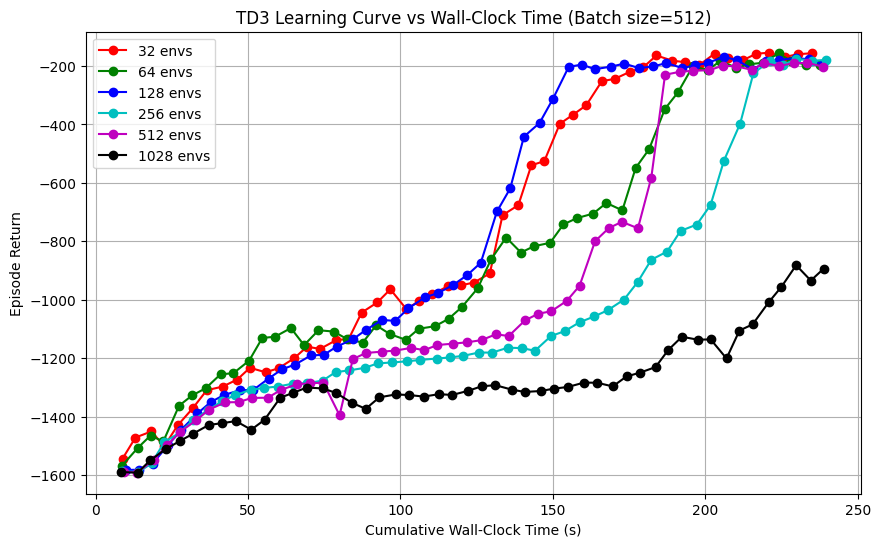

In [38]:
import matplotlib.pyplot as plt

envs_list = [32, 64, 128, 256, 512, 1028]  # different numbers of parallel envs
batch_size = 512
num_episodes = 50  # adjust as needed
colors = ['r', 'g', 'b', 'c', 'm', 'k']

plt.figure(figsize=(10,6))

for i, num_envs in enumerate(envs_list):
    print(f"Running TD3 with {num_envs} environments")
    _, _, ep_returns, ep_times = train(num_envs=num_envs, num_episodes=num_episodes, batch_size=batch_size)
    cum_times = [sum(ep_times[:j+1]) for j in range(len(ep_times))]
    plt.plot(cum_times, ep_returns, marker='o', color=colors[i], label=f"{num_envs} envs")

plt.xlabel("Cumulative Wall-Clock Time (s)")
plt.ylabel("Episode Return")
plt.title(f"TD3 Learning Curve vs Wall-Clock Time (Batch size={batch_size})")
plt.legend()
plt.grid(True)
plt.show()
